In [2]:
import numpy as np
import pandas as pd


# function to print information(shape and type of each field) of dataframe
def info(df):
    print('shape: {}.\ncolumns:\n{}\n'.format(df.shape, df.dtypes))


# ---------------------- read data -----------------------------
# since the data size is large, restrict the data type of each field
sales_train = pd.read_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/DataSets/sales_train.csv',
                          parse_dates=['date'], dtype={'date':'str', 'date_block_num':'int16', 'shop_id':'int16',
                          'item_id':'int32', 'item_price':'float32', 'item_cnt_day':'int32'} )
shops = pd.read_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/DataSets/shops.csv',
                    dtype={'shop_name':'str', 'shop_id':'int16'})
items = pd.read_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/DataSets/items.csv',
                    dtype={'item_name':'str', 'item_id':'int32', 'item_category_id':'int32'})
item_categories = pd.read_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/DataSets/item_categories.csv',
                             dtype={'item_category_name':'str', 'item_category_id':'int32'})
test = pd.read_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/DataSets/test.csv',
                  dtype={'ID':'int32', 'shop_id':'int16', 'item_id':'int32'})

# info(sales_train)
# info(test)
# ---------------------- read data -----------------------------

# ---------------------- filter train data -----------------------------
# only include the data of items exist in the test set as training set
shop_id = test['shop_id'].unique()
item_id = test['item_id'].unique()
tmp_train = sales_train[sales_train['shop_id'].isin(shop_id)]
train = tmp_train[tmp_train['item_id'].isin(item_id)]
info(train)
# ---------------------- filter train data -----------------------------

# --------------------- check duplicate or emtpy values ---------------------
print(train[train.duplicated(keep=False)])
print(train.isnull().sum()) # no empty value
# --------------------- check duplicate or emtpy values ---------------------


shape: (1224439, 6).
columns:
date              datetime64[ns]
date_block_num             int16
shop_id                    int16
item_id                    int32
item_price               float32
item_cnt_day               int32
dtype: object

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
1435365 2014-02-23              13       50     3423       999.0             1
1435367 2014-02-23              13       50     3423       999.0             1
1496765 2014-03-23              14       21     3423       999.0             1
1496766 2014-03-23              14       21     3423       999.0             1
1671872 2014-01-05              16       50     3423       999.0             1
1671873 2014-01-05              16       50     3423       999.0             1
1866322 2014-12-07              18       25     3423       999.0             1
1866340 2014-12-07              18       25     3423       999.0             1
2198564 2014-12-31              23       42   

In [3]:
# ======================= group data by month ============================
# for each item in each shop, sum the sale data according to month(data_block_num)
train_month = train.groupby(['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day': [np.sum, np.mean], 'item_price': [np.sum, np.mean]})
train_month.columns = ['date_block_num','shop_id','item_id','cnt_sum','cnt_mean','price_sum','price_mean']
# print(train_month)

# merge together with items table, getting the item_category field
# create data for each item in each shop in each month
shop_ids = train_month['shop_id'].unique()
item_ids = train_month['item_id'].unique()
month_data = []

# note the range of data_block_num is 0~33
for i in range(0, 34):
    for shop in shop_ids:
        for item in item_ids:
            month_data.append([i, shop, item])

# create table and merge with items
month_data = pd.DataFrame(month_data, columns=['date_block_num','shop_id','item_id'])
month_data = month_data.merge(items, on='item_id', how='left').drop('item_name', axis=1)

# merge with train_month
train_month = pd.merge(month_data, train_month, on=['date_block_num','shop_id','item_id'], how='left')
train_month.fillna(0, inplace=True) # fill in empty value with 0

# replace data_block_num by month & year field
train_month['year'] = train_month['date_block_num'].apply(lambda x: ((x // 12) + 2013))
train_month['month'] = train_month['date_block_num'].apply(lambda x: (x % 12) + 1)
print(train_month)
info(train_month)
# ======================= group data by month ============================

# ============= quantiles =================
print(train_month[['cnt_sum','price_sum']].quantile(0.99))
# ============= quantiles =================

         date_block_num  shop_id  item_id  item_category_id  cnt_sum  \
0                     0        2       33                37      1.0   
1                     0        2      482                73      1.0   
2                     0        2      491                73      1.0   
3                     0        2      839                73      1.0   
4                     0        2     1007                67      3.0   
...                 ...      ...      ...               ...      ...   
6734443              33       36     9103                54      0.0   
6734444              33       36     9107                54      0.0   
6734445              33       36    10204                31      0.0   
6734446              33       36    12733                76      0.0   
6734447              33       36    15925                72      0.0   

         cnt_mean  price_sum  price_mean  year  month  
0             1.0      499.0       499.0  2013      1  
1             1.0     3

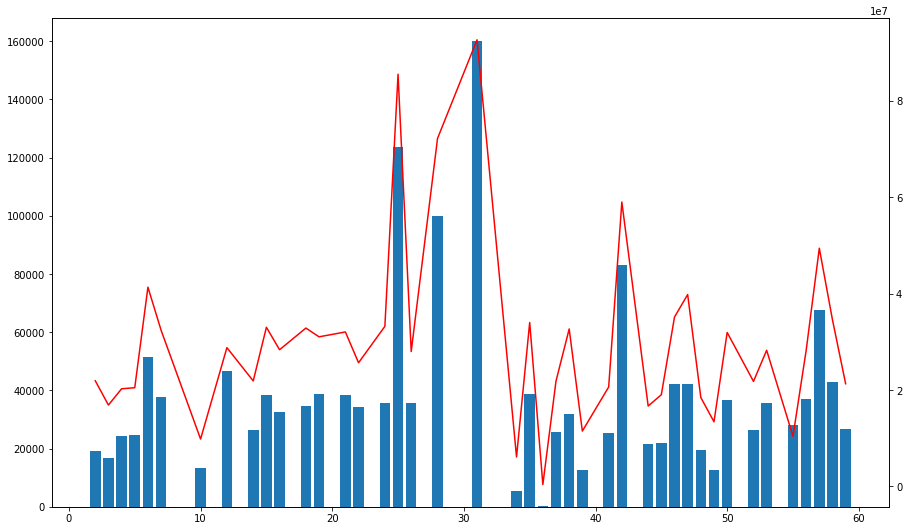

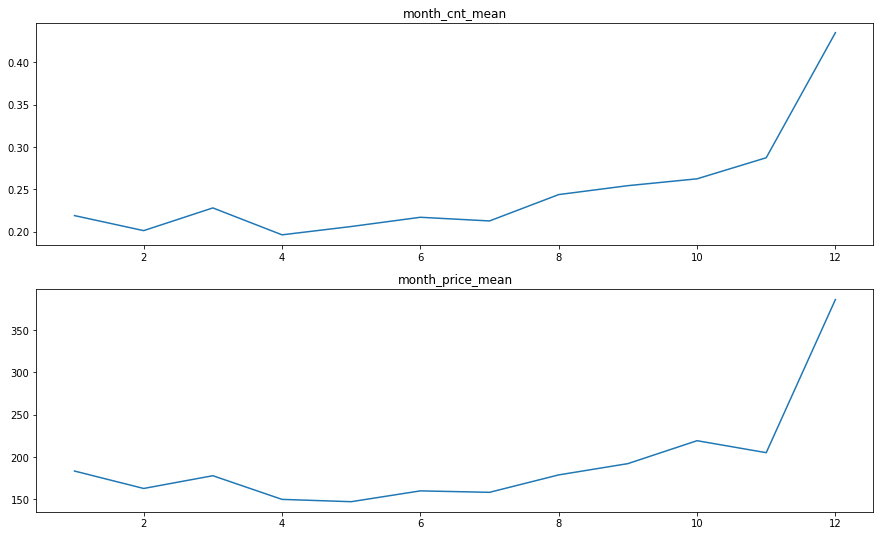

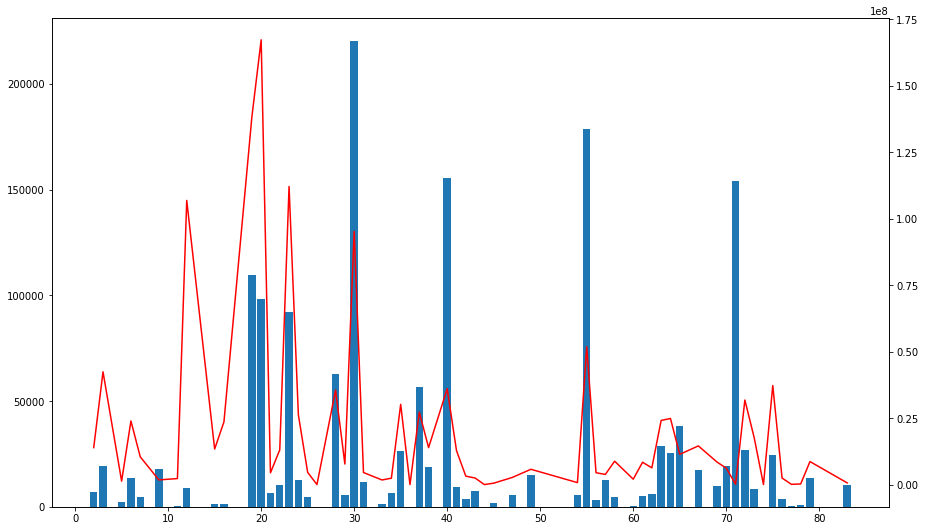

In [4]:
# =========================== plots ============================
import matplotlib.pyplot as plt

# ------------------- plot1 ---------------------
# sale of each shop
shop_df = train_month.groupby('shop_id', as_index=False).agg({'cnt_sum': np.sum, 'price_sum': np.sum})
shop_df.columns = ['shop_id','shop_cnt','shop_price']
s_name = shop_df['shop_id']
s_count = shop_df['shop_cnt']
s_price = shop_df['shop_price']

fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.bar(s_name, s_count)
ax2.plot(s_name, s_price, 'r-')
plt.show()
# ------------------- plot1 ---------------------

# ------------------- plot2 ---------------------
# sale of each month
month_df = train_month.groupby('month', as_index=False).agg({'cnt_sum': np.mean, 'price_sum': np.mean})
month_df.columns = ['month','month_cnt','month_price']
s_name = month_df['month']
s_count = month_df['month_cnt']
s_price = month_df['month_price']

fig = plt.figure(figsize=(15,9))
plt.subplot(2,1,1)
plt.title('month_cnt_mean')
plt.plot(s_name, s_count)
plt.subplot(2,1,2)
plt.plot(s_name,s_price)
plt.title('month_price_mean')
plt.show()
# ------------------- plot2 ---------------------

# ------------------- plot3 ---------------------
# sale of each category
category_df = train_month.groupby('item_category_id', as_index=False).agg({'cnt_sum': np.sum, 'price_sum': np.sum})
category_df.columns = ['item_category_id','category_cnt','category_price']
s_name = category_df['item_category_id']
s_count= category_df['category_cnt']
s_price = category_df['category_price']

fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()
ax1.bar(s_name, s_count)
ax2.plot(s_name, s_price, 'r-')
plt.show()
# ------------------- plot3 ---------------------

# =========================== plots ============================

In [5]:
# =============== feature engineering ===================

# -------------- sale feature --------------
# consider the sale of next month as a feature of the current month
train_month['cnt_next'] = train_month.sort_values('date_block_num').groupby(['shop_id','item_id'])['cnt_sum'].shift(-1)
train_month['cnt_next'].fillna(0, inplace=True)

# consider the sale of current month and previous two months, take max/min, mean and standard deviation
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

func_list = [f_min, f_max, f_mean, f_std]
func_name = ['min', 'max', 'mean', 'std']

for i in range(len(func_name)):
    f_name = 'cnt_w3_{}'.format(func_name[i])
    train_month[f_name] = train_month.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['cnt_sum'].apply(func_list[i])
    train_month[f_name].fillna(0, inplace=True)

# Move the features of previous three months to the corresponding months, 
# and calculates the change in sale as a feature
lag_list = [1, 2, 3]
train_month['cnt_trend'] = train_month['cnt_sum']

for lag in lag_list:
    f_name = 'cnt_prev{}'.format(lag)
    train_month[f_name] = train_month.sort_values('date_block_num').groupby(['shop_id','item_id'])['cnt_sum'].shift(lag)
    train_month[f_name].fillna(0, inplace=True)
    train_month['cnt_trend'] -= train_month[f_name]

train_month['cnt_trend'] /= len(lag_list) + 1


# average sale in different dimensions(shop, item, shop_item, item_category, year and month)
shop_mean = train_month.groupby('shop_id', as_index=False).agg({'cnt_sum': np.mean})
shop_mean.columns = ['shop_id','shop_mean']

item_mean = train_month.groupby('item_id', as_index=False).agg({'cnt_sum': np.mean})
item_mean.columns = ['item_id','item_mean']

shop_item_mean = train_month.groupby(['shop_id','item_id'], as_index=False).agg({'cnt_sum': np.mean})
shop_item_mean.columns = ['shop_id','item_id','shop_item_mean']

item_category_mean = train_month.groupby('item_category_id', as_index=False).agg({'cnt_sum': np.mean})
item_category_mean.columns = ['item_category_id','item_category_mean']

year_mean = train_month.groupby('year', as_index=False).agg({'cnt_sum': np.mean})
year_mean.columns = ['year','year_mean']

month_mean = train_month.groupby('month', as_index=False).agg({'cnt_sum': np.mean})
month_mean.columns = ['month','month_mean']

# merge data together into the training set
train_month = train_month.merge(shop_mean, on='shop_id', how='left')\
                         .merge(item_mean, on='item_id', how='left')\
                         .merge(shop_item_mean, on=['shop_id','item_id'], how='left')\
                         .merge(item_category_mean, on='item_category_id', how='left')\
                         .merge(year_mean, on='year', how='left')\
                         .merge(month_mean, on='month', how='left')
# -------------- sale feature --------------

# -------------- filling in missing values ---------------
# print(train_month.columns.values)
# use median of each column to fill in null values
for col in ['cnt_trend', 'cnt_prev1', 'cnt_prev2', 'cnt_prev3']:
    for shop in train_month['shop_id'].unique():
        shop_median = train_month[(train_month['shop_id'] == shop)][col].median()
        train_month.loc[(train_month[col].isnull()) & (train_month['shop_id'] == shop), col] = shop_median
        
# print(train_month)
# temp = train_month[train_month['shop_id'] == 2]
# temp1 = temp[temp['item_id'] == 33]
# temp1.to_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/temp1.csv')
# temp2 = temp[temp['item_id'] == 1007]
# temp2.to_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/temp2.csv')
# -------------- filling in missing values ---------------

# -------------- change data type ----------------
# use smaller data types to save memory space
train_month[['date_block_num','shop_id','item_category_id','month']] = train_month[['date_block_num','shop_id','item_category_id','month']].astype('int8')
train_month[['item_id','year','cnt_sum']] = train_month[['item_id','year','cnt_sum']].astype('int32')
# -------------- change data type ----------------

info(train_month)

# =============== feature engineering ===================

shape: (6734448, 25).
columns:
date_block_num           int8
shop_id                  int8
item_id                 int32
item_category_id         int8
cnt_sum                 int32
cnt_mean              float64
price_sum             float32
price_mean            float32
year                    int32
month                    int8
cnt_next              float64
cnt_w3_min            float64
cnt_w3_max            float64
cnt_w3_mean           float64
cnt_w3_std            float64
cnt_trend             float64
cnt_prev1             float64
cnt_prev2             float64
cnt_prev3             float64
shop_mean             float64
item_mean             float64
shop_item_mean        float64
item_category_mean    float64
year_mean             float64
month_mean            float64
dtype: object



In [6]:
# ============= prepare dataset ===============

# choose data with sale lower than 20 and price lower than 40000
train_final = train_month.query('cnt_sum >= 0 and cnt_sum <= 20 and price_sum <= 40000')

# divide data into train, validation and test set
train_set = train_final.query('date_block_num >= 3 and date_block_num < 28')
validation_set = train_final.query('date_block_num >= 28 and date_block_num < 33')
test_set = train_final.query('date_block_num == 33')

train_y = train_set['cnt_sum']
train_X = train_set.drop('cnt_sum', axis=1)

validation_y = validation_set['cnt_sum']
validation_X = validation_set.drop('cnt_sum', axis=1)

test_y = test_set['cnt_sum']
test_X = test_set.drop('cnt_sum', axis=1)

# features used to train
f_features = ['shop_id', 'item_id', 'item_category_id', 'cnt_mean', 'price_mean',
              'cnt_prev1', 'cnt_prev2', 'cnt_prev3', 'cnt_trend']

# ============= prepare dataset ===============

In [7]:
from sklearn.linear_model import LinearRegression

# ============= Linear Regression model ==============

LR_train_y = train_final['cnt_sum']    # label
LR_train_X = train_final[f_features]       # training set

lr_model = LinearRegression().fit(LR_train_X, LR_train_y) # training model

LR_test_X = test_X[f_features] # features to predict on
pred = lr_model.predict(LR_test_X) # fit

# append prediction results to table with shop_id and item_id
pred_results = test_X[['shop_id', 'item_id']]
pred_results['test'] = pred

# create submission file by merging two tables and keep the required columns
submission = pd.merge(test, pred_results, on=['shop_id','item_id'], how='left')
submission.fillna(0, inplace=True)
submission.columns = ['ID','shop_id','item_id','item_cnt_month']
submission = submission[['ID','item_cnt_month']]

submission.to_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/LR_model_predictions.csv', index=False)

# ============= Linear Regression model ==============

/var/folders/q7/r0r8t2hs5q587wkmr7vjs1tm0000gn/T/ipykernel_16796/2275091007.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_results['test'] = pred


In [8]:
# ========================== Model Ensemble ==============================

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# function to calculate rmse
def calculate_rmse(true_y, pred_y, pred_info):
    print('{}: {}'.format(pred_info, np.sqrt(mean_squared_error(true_y, pred_y))))


# standard process of model trainning
def model_train(func_name, func):
    model = func
    model.fit(f_train_X, train_y)
    pred = model.predict(f_test_X)
    calculate_rmse(test_y, pred, func_name)


# ---------------- fit multiple models --------------
# model name and parameters
models = [('LinearRegression', LinearRegression()),
          ('DecisionTree', DecisionTreeRegressor()),
          ('RandomForest', RandomForestRegressor())]


f_train_X = train_X[f_features]
f_validation_X = validation_X[f_features]
f_test_X = test_X[f_features]

# generate models
for name, model in models:
    model_train(name, model)
# ---------------- fit multiple models --------------

# ------------------- ensemble ---------------------
'''
First Level:
Apply trainging dataset (train_X, train_y) to Linear Regression, Decision Tree and Random Forest models, 
generating first-level model (first_model: lr_model, cart_model, rf_model)
Predict on train_X, the results (pred_first: pred_first_lr, pred_first_cart, pred_first_rf) are used as the input of the second level

Second Level:
Apply dataset (pred_first, train_y) to Linear Regression Model, generating the final model

Prediction:
Use the Second Level model to predict based on the results of the first level
'''
def ensemble_model(train_X, train_y, test_X):
    # 第一层模型：生成
    lr_model = LinearRegression().fit(train_X, train_y)
    dt_model = DecisionTreeRegressor().fit(train_X, train_y)
    rf_model = RandomForestRegressor().fit(train_X, train_y)

    # 组合成为二层模型的输入
    first_level = pd.DataFrame(lr_model.predict(train_X), columns=['LR'])
    first_level['DT'] = dt_model.predict(train_X)
    first_level['RF'] = rf_model.predict(train_X)

    # 第二层模型：生成
    second_model = LinearRegression().fit(first_level, train_y)
    
    # 第一层预测
    first_level = pd.DataFrame(lr_model.predict(test_X), columns=['LR'])
    first_level['DT'] = dt_model.predict(test_X)
    first_level['RF'] = rf_model.predict(test_X)
    
    # 第二层预测
    second_pred = second_model.predict(first_level)
    return second_pred


second_pred = ensemble_model(f_train_X, train_y, f_validation_X)

calculate_rmse(validation_y, second_pred, 'essembled_model')
# ------------------- ensemble ---------------------

# ------------------ predict and generate final result --------------

pred = ensemble_model(f_train_X, train_y, f_test_X)

pred_test = test_X[['shop_id','item_id']]
pred_test['pred'] = pred

submission = pd.merge(test, pred_test, on=['shop_id','item_id'], how='left')
submission.fillna(0, inplace=True)
submission.columns = ['ID','shop_id','item_id','item_cnt_month']
submission = submission[['ID','item_cnt_month']]

submission.to_csv('/Users/wuruotian/Desktop/Kaggle/kaggle_project/Predict_Future_Sales/essembled_model_predictions.csv', index=False)


# ------------------ predict and generate final result --------------

# ========================== Model Ensemble ==============================

LinearRegression: 6.631069760316023e-14
DecisionTree: 0.1725720228736741
RandomForest: 0.11207741633537924
essembled_model: 0.1936449347961361


/var/folders/q7/r0r8t2hs5q587wkmr7vjs1tm0000gn/T/ipykernel_16796/2112755101.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_test['pred'] = pred
